# ResNet Ablation Study

## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras 
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1) ResNet 기본 블록 구성하기

In [3]:
def conv_block(layer, channel, kernel_size, strides=1, activation='relu', name='0'):
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            padding='same',
                            strides=strides,
                            name=f'conv_{name}')(layer)
    x = keras.layers.BatchNormalization(name=f'bn_{name}')(x)
    if activation:
      x = keras.layers.Activation(activation, name=f'activation_{name}')(x)
    
    return x

## 2) ResNet-34, ResNet-50 Complete Model
### Input Shape=(32,32,3)

In [4]:
def build_residual_block(input_layer, block_num, num_cnn, channel, is_50):
    x = input_layer
    
    # resnet_34
    if is_50 == False:
        for i in range(num_cnn):
            if block_num>0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None, name=f'shortcut_{block_num+2}_{i+1}')
                x = conv_block(x, channel, (3,3), strides=2, name=f'{block_num+2}_{i+1}_1', activation='relu')
                x = conv_block(x, channel, (3,3), name=f'{block_num+2}_{i+2}_2', activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3), name=f'{block_num+2}_{i+1}_1', activation='relu')
                x = conv_block(x, channel, (3,3), name=f'{block_num+2}_{i+2}_2', activation=None)

            x = keras.layers.Add(name=f'shorcut_add_{block_num+2}_{i+1}')([x,shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_activation_{block_num+2}_{i+1}')(x)
    # resnet_50
    else:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None, name=f'shortcut_{block_num+2}_{i+1}')
                x = conv_block(x, channel, (1,1), strides=2, name=f'{block_num+2}_{i+1}_1', activation='relu')
                x = conv_block(x, channel, (3,3), name=f'{block_num+2}_{i+2}_2', activation='relu')
                x = conv_block(x, channel*4, (1,1), name=f'{block_num+2}_{i+3}_3', activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1), name=f'{block_num+2}_{i+1}_1', activation='relu')
                x = conv_block(x, channel, (3,3), name=f'{block_num+2}_{i+2}_2', activation='relu')
                x = conv_block(x, channel*4, (1,1), name=f'{block_num+2}_{i+3}_3', activation=None)


            x = keras.layers.Add(name=f'shorcut_add_{block_num+2}_{i+1}')([x,shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_activation_{block_num+2}_{i+1}')(x)

    return x

In [5]:
def build_resnet(input_shape, num_cnn_list, channel_list, is_50, num_classes=10, name ='ResNet_34'):
  
    assert len(num_cnn_list) is len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='input_layer')
    output = input_layer
    
    output = conv_block(output, 64, (7,7), strides=2, activation='relu', name='stage1_1_conv1')
    output = layers.MaxPool2D(pool_size=(2,2), strides=2)(output)
    
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_residual_block(output, block_num, num_cnn, channel, is_50)
        
    
    output = layers.GlobalAveragePooling2D(name='GAP')(output)
    output = layers.Flatten()(output)
    output = layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    return model

In [6]:
resnet_34 = build_resnet(input_shape=(32,32,3),
                         num_cnn_list=[3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512], 
                         is_50=False,
                         name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_stage1_1_conv1 (Conv2D)    (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
bn_stage1_1_conv1 (BatchNormali (None, 16, 16, 64)   256         conv_stage1_1_conv1[0][0]        
__________________________________________________________________________________________________
activation_stage1_1_conv1 (Acti (None, 16, 16, 64)   0           bn_stage1_1_conv1[0][0]          
__________________________________________________________________________________________

In [7]:
resnet_50 = build_resnet(input_shape=(32,32,3),
                         num_cnn_list=[3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512], 
                         is_50=True,
                         name='ResNet_50')
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_stage1_1_conv1 (Conv2D)    (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
bn_stage1_1_conv1 (BatchNormali (None, 16, 16, 64)   256         conv_stage1_1_conv1[0][0]        
__________________________________________________________________________________________________
activation_stage1_1_conv1 (Acti (None, 16, 16, 64)   0           bn_stage1_1_conv1[0][0]          
__________________________________________________________________________________________

### Input shape=(224,224,3)

In [8]:
resnet_34 = build_resnet(input_shape=(224,224,3),
                         num_cnn_list=[3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512], 
                         is_50=False,
                         name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_stage1_1_conv1 (Conv2D)    (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
bn_stage1_1_conv1 (BatchNormali (None, 112, 112, 64) 256         conv_stage1_1_conv1[0][0]        
__________________________________________________________________________________________________
activation_stage1_1_conv1 (Acti (None, 112, 112, 64) 0           bn_stage1_1_conv1[0][0]          
__________________________________________________________________________________________

In [9]:
resnet_50 = build_resnet(input_shape=(224,224,3),
                         num_cnn_list=[3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512], 
                         is_50=True,
                         name='ResNet_50')
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_stage1_1_conv1 (Conv2D)    (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
bn_stage1_1_conv1 (BatchNormali (None, 112, 112, 64) 256         conv_stage1_1_conv1[0][0]        
__________________________________________________________________________________________________
activation_stage1_1_conv1 (Acti (None, 112, 112, 64) 0           bn_stage1_1_conv1[0][0]          
__________________________________________________________________________________________

## 3) 일반 네트워크(plain network) 만들기

In [10]:
def build_plain_block(input_layer, block_num, num_cnn, channel, is_50):
    x = input_layer
    
    # plain_34
    if is_50 == False:
        for i in range(num_cnn):
            if block_num>0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2, name=f'{block_num+2}_{i+1}_1', activation='relu')
                x = conv_block(x, channel, (3,3), name=f'{block_num+2}_{i+2}_2', activation='relu')
            else:
                x = conv_block(x, channel, (3,3), name=f'{block_num+2}_{i+1}_1', activation='relu')
                x = conv_block(x, channel, (3,3), name=f'{block_num+2}_{i+2}_2', activation='relu')

    # plain_50
    else:
        for i in range(num_cnn):
            if block_num>0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2, name=f'{block_num+2}_{i+1}_1', activation='relu')
                x = conv_block(x, channel, (3,3), name=f'{block_num+2}_{i+2}_2', activation='relu')
                x = conv_block(x, channel*4, (1,1), name=f'{block_num+2}_{i+3}_3', activation='relu')
            else:
                x = conv_block(x, channel, (1,1), name=f'{block_num+2}_{i+1}_1', activation='relu')
                x = conv_block(x, channel, (3,3), name=f'{block_num+2}_{i+2}_2', activation='relu')
                x = conv_block(x, channel*4, (1,1), name=f'{block_num+2}_{i+3}_3', activation='relu')

    return x

In [11]:
def build_plain(input_shape, num_cnn_list, channel_list, is_50, num_classes=10, name ='Plain_34'):
  
    assert len(num_cnn_list) is len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='input_layer')
    output = input_layer
    
    output = conv_block(output, 64, (7,7), strides=2, activation='relu', name='stage1_1_conv1')
    output = layers.MaxPool2D(pool_size=(2,2), strides=2)(output)
    
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_plain_block(output, block_num, num_cnn, channel, is_50)
        
    
    output = layers.GlobalAveragePooling2D(name='GAP')(output)
    output = layers.Flatten()(output)
    output = layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    return model

In [12]:
plain_34 = build_plain(input_shape=(224,224,3),
                         num_cnn_list=[3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512], 
                         is_50=False,
                         name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_stage1_1_conv1 (Conv2D) (None, 112, 112, 64)      9472      
_________________________________________________________________
bn_stage1_1_conv1 (BatchNorm (None, 112, 112, 64)      256       
_________________________________________________________________
activation_stage1_1_conv1 (A (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv_2_1_1 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
bn_2_1_1 (BatchNormalization (None, 56, 56, 64)        256

In [13]:
plain_50 = build_plain(input_shape=(224,224,3),
                         num_cnn_list=[3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512], 
                         is_50=True,
                         name='Plain_50')
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_stage1_1_conv1 (Conv2D) (None, 112, 112, 64)      9472      
_________________________________________________________________
bn_stage1_1_conv1 (BatchNorm (None, 112, 112, 64)      256       
_________________________________________________________________
activation_stage1_1_conv1 (A (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv_2_1_1 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
bn_2_1_1 (BatchNormalization (None, 56, 56, 64)        256

## 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

## Data Load

In [14]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [15]:
# Tensorflow 데이터셋 feature 정보 확인
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [16]:
# 데이터의 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


## Input Normalization

In [17]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224, 224))
    return tf.cast(image, tf.float32) / 255., label

In [18]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [19]:
ds_info.features["label"].names

['cat', 'dog']

In [20]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

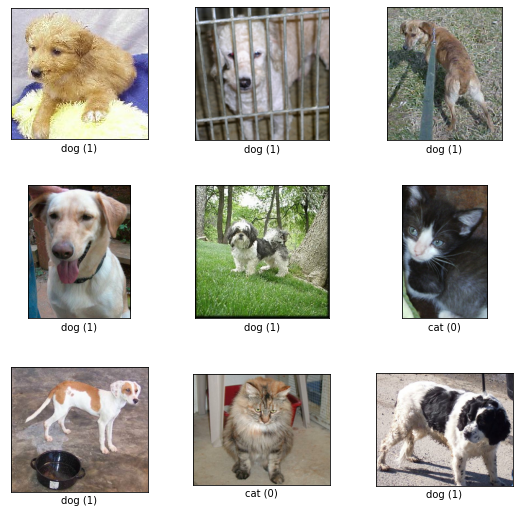

In [21]:
fig = tfds.show_examples(ds_train, ds_info)

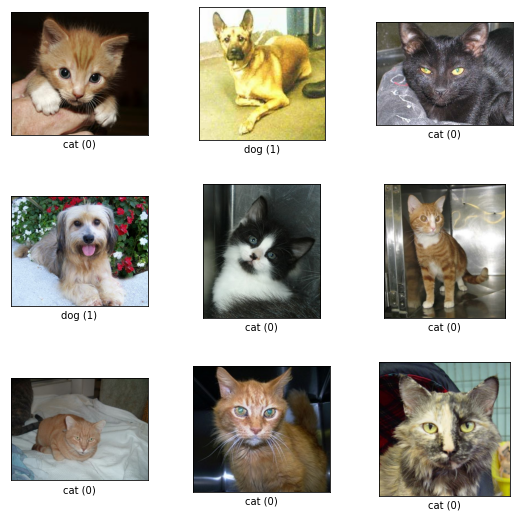

In [22]:
fig = tfds.show_examples(ds_test, ds_info)

In [23]:
BATCH_SIZE = 32
EPOCH = 20

In [24]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

## 하이퍼 파라미터 설정 및 callback 파라미터 추가

In [33]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, monitor='val_loss', patience=1, verbose=2, min_lr=1e-6)

In [34]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 93s 147ms/step - loss: 0.6909 - accuracy: 0.5854 - val_loss: 0.6838 - val_accuracy: 0.6032
Epoch 2/20
581/581 [==============================] - 78s 134ms/step - loss: 0.6740 - accuracy: 0.5938 - val_loss: 0.7332 - val_accuracy: 0.5123

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 3/20
581/581 [==============================] - 78s 134ms/step - loss: 0.6703 - accuracy: 0.5871 - val_loss: 0.6995 - val_accuracy: 0.5795

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 4/20
581/581 [==============================] - 78s 134ms/step - loss: 0.6385 - accuracy: 0.6402 - val_loss: 0.6344 - val_accuracy: 0.6394
Epoch 5/20
581/581 [==============================] - 78s 134ms/step - loss: 0.6303 - accuracy: 0.6463 - val_loss: 0.6320 - val_accuracy: 0.6384
Epoch 6/20
581/581 [==============================] - 78s 133ms/step - loss: 0.6310 - accuracy: 0.6445 - val_loss:

In [35]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 89s 140ms/step - loss: 0.8444 - accuracy: 0.5956 - val_loss: 0.6262 - val_accuracy: 0.6580
Epoch 2/20
581/581 [==============================] - 81s 139ms/step - loss: 0.6212 - accuracy: 0.6623 - val_loss: 1.4433 - val_accuracy: 0.5500

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 3/20
581/581 [==============================] - 83s 144ms/step - loss: 0.4966 - accuracy: 0.7582 - val_loss: 0.4382 - val_accuracy: 0.7918
Epoch 4/20
581/581 [==============================] - 82s 141ms/step - loss: 0.4247 - accuracy: 0.8025 - val_loss: 0.4365 - val_accuracy: 0.7924
Epoch 5/20
581/581 [==============================] - 82s 141ms/step - loss: 0.3902 - accuracy: 0.8230 - val_loss: 0.4511 - val_accuracy: 0.7948

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 6/20
581/581 [==============================] - 82s 141ms/step - loss: 0.3315 - accuracy: 0.8579 - val_loss:

In [36]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 128s 205ms/step - loss: 0.9001 - accuracy: 0.4989 - val_loss: 0.6920 - val_accuracy: 0.4844
Epoch 2/20
581/581 [==============================] - 118s 204ms/step - loss: 0.6916 - accuracy: 0.5563 - val_loss: 0.6977 - val_accuracy: 0.5063

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 3/20
581/581 [==============================] - 118s 204ms/step - loss: 0.6702 - accuracy: 0.5930 - val_loss: 0.6688 - val_accuracy: 0.5961
Epoch 4/20
581/581 [==============================] - 118s 204ms/step - loss: 0.6665 - accuracy: 0.5952 - val_loss: 0.6848 - val_accuracy: 0.5963

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 5/20
581/581 [==============================] - 118s 204ms/step - loss: 0.6548 - accuracy: 0.6198 - val_loss: 0.6525 - val_accuracy: 0.6335
Epoch 6/20
581/581 [==============================] - 118s 204ms/step - loss: 0.6492 - accuracy: 0.6263 - val

In [37]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 70s 104ms/step - loss: 0.6510 - accuracy: 0.6952 - val_loss: 0.4953 - val_accuracy: 0.7626
Epoch 2/20
581/581 [==============================] - 60s 103ms/step - loss: 0.4136 - accuracy: 0.8115 - val_loss: 0.4307 - val_accuracy: 0.8052
Epoch 3/20
581/581 [==============================] - 60s 103ms/step - loss: 0.3023 - accuracy: 0.8719 - val_loss: 1.3869 - val_accuracy: 0.6779

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 4/20
581/581 [==============================] - 60s 103ms/step - loss: 0.2194 - accuracy: 0.9103 - val_loss: 0.2575 - val_accuracy: 0.8998
Epoch 5/20
581/581 [==============================] - 60s 103ms/step - loss: 0.1207 - accuracy: 0.9524 - val_loss: 0.2661 - val_accuracy: 0.9086

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 6/20
581/581 [==============================] - 60s 103ms/step - loss: 0.0799 - accuracy: 0.9726 - val_loss:

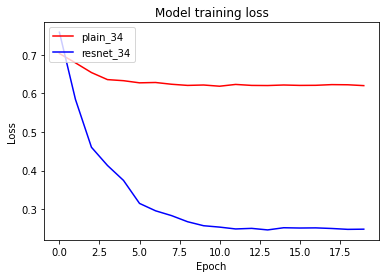

In [38]:
plt.plot(history_plain_34.history['loss'], 'r')
plt.plot(history_resnet_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain_34', 'resnet_34'], loc='upper left')
plt.show()

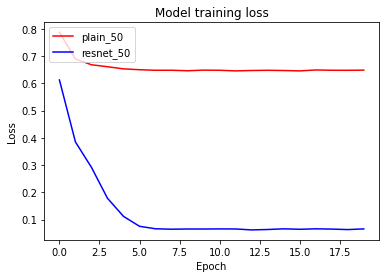

In [39]:
plt.plot(history_plain_50.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain_50', 'resnet_50'], loc='upper left')
plt.show()

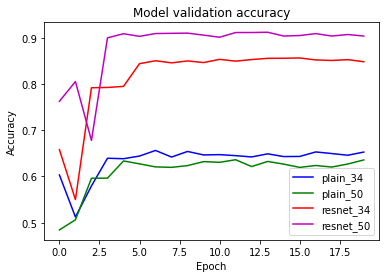

In [40]:
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.plot(history_plain_50.history['val_accuracy'], 'g')
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain_34', 'plain_50', 'resnet_34', 'resnet_50'], loc='lower right')
plt.show()

## 루브릭

1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?

- 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.
2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?

- cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.
3. Ablation Study 결과가 바른 포맷으로 제출되었는가?

- ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

- skip connection을 사용하지 않은 plain 모델의 경우 layer를 34에서 50으로 증가시키면 성능이 떨어지는 것을 확인할 수 있다.
- 반면에, skip connection을 사용한 resnet의 경우에는 layer를 같은 크기로 증가시키면 성능이 향상되는 것을 알 수 있다. 
- layer가 깊어지면 발생하는 degradation problem를 resnet을 사용하여 학습하면 이를 해결할 수 있다.

In [ ]:
ㅊ